# Calibration scores

Confidence is estimated using MC dropout, by taking mean softmax output of all n dropout runs.

Calibration plots show the fraction of true positives within all predictions in a certain confidence bin. The histogram shows the amount of predictions in confidence bins. These plots are generated for both per-vertex and per-cluster values. Per-cluster confidences are the mean of confidence values within one cluster.

The expected calibration error is the absolute differences of per-bin frequencies and confidences, weighted by the number of predictions in each bin. Lower is better, 0 is best. 

These scores are inspired from https://arxiv.org/pdf/1911.13273.pdf


NOTES:
- confidence with dropout is underconfident otherwise overconfident. Might need to tune dropout parameter to get good model in the middle.
- should tune dropout parameter on trainval & confirm on test (?)
- per-cluster confidences look only at confidences high-saliency vertices

In [1]:
from meld_graph.evaluation import load_prediction, Evaluator
from meld_graph.experiment import Experiment
from meld_graph.dataset import GraphDataset
import meld_graph.confidence
import h5py
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Setting MELD_DATA_PATH to /home/co-spit1/meld_data
Setting BASE_PATH to /home/co-spit1/meld_data
Setting EXPERIMENT_PATH to /home/co-spit1/meld_experiments/co-spit1
Setting FS_SUBJECTS_PATH to /home/co-spit1/meld_data/output/fs_outputs
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1


In [2]:
import importlib
importlib.reload(meld_graph.confidence)

<module 'meld_graph.confidence' from '/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py'>

## evaluate model with MC dropout

run 
```
python calculate_dropout_confidence.py --model_path '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all' --split test --model_name ensemble_best_model.pt --p 0.8 --n 10
```

In [3]:
#model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all'
#exp = Experiment.from_folder(model_name)
#features = exp.data_parameters['features']
#cohort = exp.cohort

## get dataset - and create Evaluator from this
#train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
#dataset = GraphDataset(test_ids[:10], exp.cohort, exp.data_parameters, mode="test")

#eva = Evaluator(exp, dataset=dataset, model_name='ensemble_best_model.pt', checkpoint_path=exp.experiment_path)

#eva.enable_mc_dropout(p=0.2, n=10)
##eva.disable_mc_dropout()

#eva.load_predict_data()

#eva.threshold_and_cluster()

## Load data for calibration plots

In [4]:
# model paths
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all'
model_name = 'ensemble_best_model.pt'

# load experiment
exp = Experiment.from_folder(model_path)
features = exp.data_parameters['features']
cohort = exp.cohort

# load evaluator with small dataset (don't need this dataset, but want to keep loading time down)
train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
dataset = GraphDataset(test_ids[:1], exp.cohort, exp.data_parameters, mode="test")
eva = Evaluator(exp, dataset=dataset, model_name=model_name, thresh_and_clust=True)  
# thresh_and_clust flag needed such that loads sigmoid parameters from file

prediction_fname = os.path.join(model_path, f'results/predictions.hdf5')
subjects = list(h5py.File(prediction_fname, 'r').keys())
print(len(subjects))

Initialised Experiment 23-08-30_IGKW_object_save_final/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H2_15T_FCD_0001
Evaluation test, min area threshold=100, threshold sigmoid(ymin=0.05, ymax=0.3, k=1.0, m=0.05)
Predicting model without dropout


453


## calibration plot without dropout

/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:153: RuntimeWarning: invalid value encountered in double_scalars
  freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:154: RuntimeWarning: invalid value encountered in double_scalars
  conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))


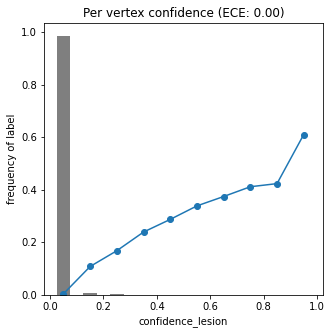

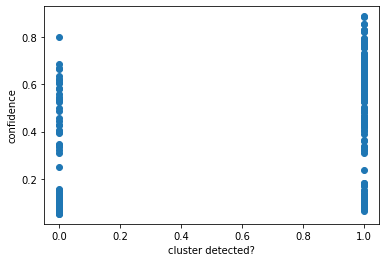

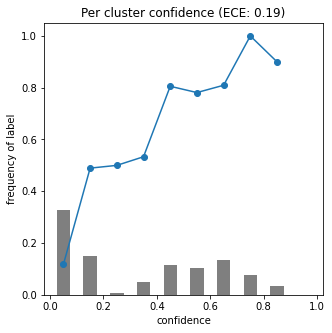

In [5]:
suffix = ""

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:153: RuntimeWarning: invalid value encountered in double_scalars
  freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:154: RuntimeWarning: invalid value encountered in double_scalars
  conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))


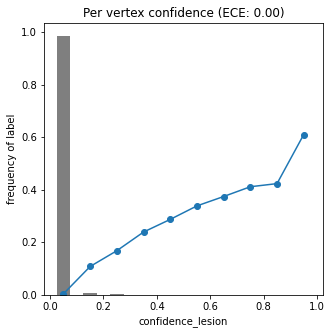

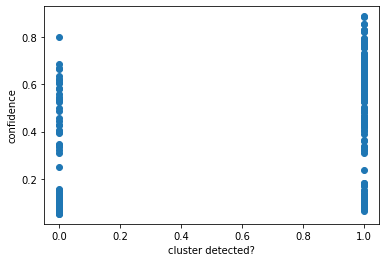

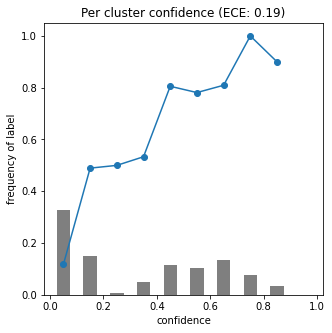

In [6]:
# this should be the same as no dropout
suffix = "_dropout1.0"

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

## calibration plot with dropout

/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:153: RuntimeWarning: invalid value encountered in double_scalars
  freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:154: RuntimeWarning: invalid value encountered in double_scalars
  conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))


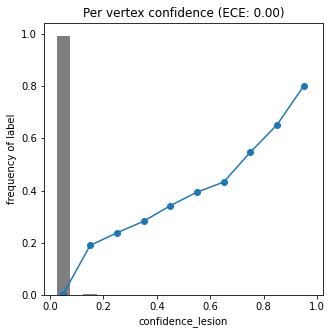

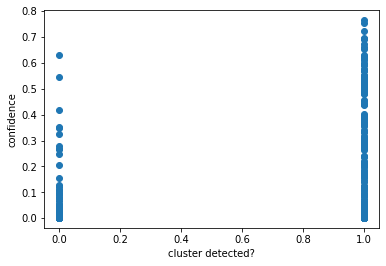

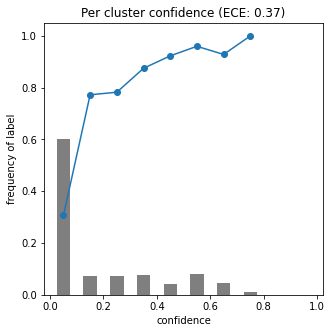

In [6]:
suffix = "_dropout0.5"

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

In [7]:
suffix = "_dropout0.6"

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

310


In [ ]:
suffix = "_dropout0.7"

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:153: RuntimeWarning: invalid value encountered in double_scalars
  freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:154: RuntimeWarning: invalid value encountered in double_scalars
  conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))


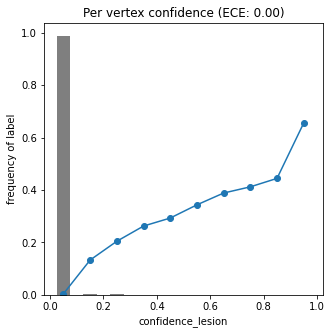

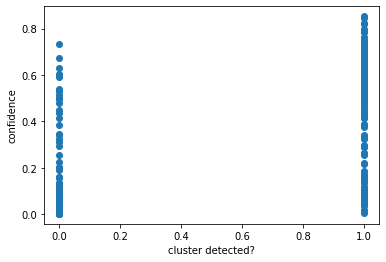

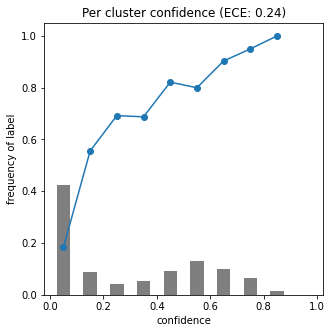

In [8]:
suffix = "_dropout0.8"

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:153: RuntimeWarning: invalid value encountered in double_scalars
  freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
/home/co-spit1/software/meld_classifier_GDL/meld_graph/confidence.py:154: RuntimeWarning: invalid value encountered in double_scalars
  conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))


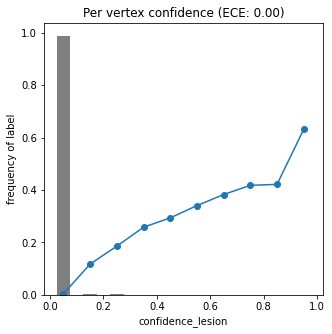

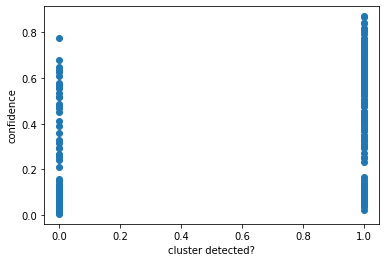

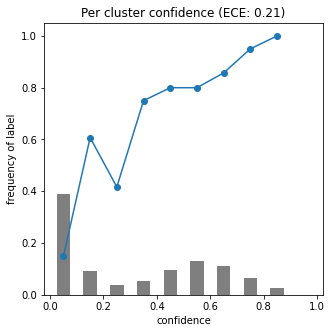

In [7]:
suffix = "_dropout0.9"

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, confidence_suffix=suffix)
fig1 = meld_graph.confidence.calibration_plot(results_dict)

# per cluster confidence
per_cluster_confidence, per_cluster_label = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')

# quick check to see if this roughtly makes sense - FP clusters should have low confidence
plt.figure()
plt.plot(per_cluster_label, per_cluster_confidence, 'o')
plt.ylabel('confidence')
plt.xlabel('cluster detected?')

fig2 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

## Calculate confidence for a given subject

In [9]:
# define subject and model
subj_id = 'MELD_H2_15T_FCD_0009'
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all'
model_name = 'ensemble_best_model.pt'
# dropout parameters
p = 0.5
n = 10

# load experiment
exp = Experiment.from_folder(model_path)
features = exp.data_parameters['features']
cohort = exp.cohort

# load evaluator with small dataset (don't need this dataset, but want to keep loading time down)
train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
dataset = GraphDataset([subj_id], exp.cohort, exp.data_parameters, mode="test")
eva = Evaluator(exp, dataset=dataset, model_name=model_name, thresh_and_clust=True, checkpoint_path=exp.experiment_path)  
# thresh_and_clust flag needed such that loads sigmoid parameters from file

Initialised Experiment 23-08-30_IGKW_object_save_final/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H2_15T_FCD_0009
Evaluation test, min area threshold=100, threshold sigmoid(ymin=0.05, ymax=0.3, k=1.0, m=0.05)
Creating model
Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all/ensemble_best_model.pt
Predicting model without dropout


In [10]:
# predict subject without dropout
eva.disable_mc_dropout()
eva.load_predict_data(save_prediction=False)
eva.threshold_and_cluster(save_prediction=False)

results_dict = meld_graph.confidence.get_lesion([subj_id], cohort)
# get prediction from results in eva
results_dict[subj_id]['prediction'] = (eva.data_dictionary[subj_id]['cluster_thresholded'] > 0).astype(int)
results_dict[subj_id]['clusters'] = eva.data_dictionary[subj_id]['cluster_thresholded']

# for comparison, confidence scores without dropout
results_dict[subj_id]['confidence_lesion'] = eva.data_dictionary[subj_id]['result']
results_dict[subj_id]['confidence_nonlesion'] = 1 - results_dict[subj_id]['confidence_lesion']

confidence_arr, labels_arr = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')
print('confidence (no MC dropout): {:0.3f}'.format(confidence_arr[0]), 'correct prediction: {}'.format(labels_arr[0]))

Predicting model without dropout
loading data and predicting model
/home/co-spit1/software/meld_classifier_GDL/meld_graph/evaluation.py:310: RuntimeWarning: invalid value encountered in true_divide
  x = 1 - self.roc_dictionary["specificity"] / self.roc_dictionary["specificity"][-1]


confidence (no MC dropout): 0.690 correct prediction: 1


In [11]:
# predict subject with dropout for confidence values
eva.enable_mc_dropout(p=p, n=n)

eva.load_predict_data(save_prediction=False)
eva.threshold_and_cluster(save_prediction=False)

# get confidence from results in eva
results_dict[subj_id]['confidence_lesion'] = eva.data_dictionary[subj_id]['result']
results_dict[subj_id]['confidence_nonlesion'] = 1 - results_dict[subj_id]['confidence_lesion']

confidence_arr, labels_arr = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='median')
print('confidence (with MC dropout): {:0.3f}'.format(confidence_arr[0]), 'correct prediction: {}'.format(labels_arr[0]))

Predicting model with droput (p=0.5, n=10)
loading data and predicting model


confidence (with MC dropout): 0.522 correct prediction: 1


/home/co-spit1/software/meld_classifier_GDL/meld_graph/evaluation.py:310: RuntimeWarning: invalid value encountered in true_divide
  x = 1 - self.roc_dictionary["specificity"] / self.roc_dictionary["specificity"][-1]
